## Classificação de Redes Complexas

Importamos todas as bibliotecas necessárias para o projeto

In [9]:
import os
import networkx as nx
import pandas as pd
import math
import matplotlib.pyplot as plt
import statistics as stat
from collections import Counter
import random
import sklearn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

Agora definimos funções auxiliares. 


`plot_attacks` simula ataques e falhas randômicas em redes

In [10]:
def plot_attacks(G, attack_type):
  if attack_type != "targeted" and attack_type != "random":
    print("Possible attack types: 'targeted' and 'random'.")
    return

  C = G.copy()
  N = C.number_of_nodes()
  number_of_steps = 25
  M = N // number_of_steps
  random_attack_core_proportions = []
  num_nodes_removed = range(0, N, M)
  for nodes_removed in num_nodes_removed:
      # Measure the relative size of the network core
      core = next(nx.connected_components(C))
      core_proportion = len(core) / N
      random_attack_core_proportions.append(core_proportion)
      
      # If there are more than M nodes, select M nodes at random and remove them
      if C.number_of_nodes() > M:
        if attack_type == "random":
          nodes_to_remove = random.sample(list(C.nodes), M)
          C.remove_nodes_from(nodes_to_remove)
        elif attack_type == "targeted":
          nodes_sorted_by_degree = sorted(C.nodes, key=C.degree, reverse=True)
          nodes_to_remove = nodes_sorted_by_degree[:M]
          C.remove_nodes_from(nodes_to_remove)
  
  plt.title(attack_type)
  plt.xlabel('Number of nodes removed')
  plt.ylabel('Proportion of nodes in core')
  plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')

A classe `Graph` pode ser instanciada para definir um grafo, características e realizar uma análise

In [16]:
class Graph():
  def __init__(self, graph, name):
    self.G = graph
    self.name = name
    self.deg_list = [self.G.degree(n) for n in self.G.nodes()]
    self.nodes = nx.number_of_nodes(self.G)
    self.edges = nx.number_of_edges(self.G)
    self._density = nx.density(self.G)
    self._da_coeff = nx.degree_assortativity_coefficient(self.G)
    if(nx.is_connected(self.G)):
      self._spl_mean = nx.average_shortest_path_length(self.G)
    else:
      closeness_centr = nx.closeness_centrality(self.G)
      self._spl_mean = stat.mean(closeness_centr)
    nodes_clustering = nx.clustering(self.G)
    self._c_mean = stat.mean(nodes_clustering.values())
    self._c_stdev = stat.stdev(nodes_clustering.values())
    self._dg_mean = stat.mean(self.deg_list)
    self._dg_stdev = stat.stdev(self.deg_list)
    self.dg_median = stat.median(self.deg_list)
    betweenness = nx.betweenness_centrality(self.G)
    self.betweenness_sequence = list(betweenness.values())
    self._bt_mean = stat.mean(self.betweenness_sequence)
    self._bt_stdev = stat.stdev(self.betweenness_sequence)
    self._bt_median = stat.median(self.betweenness_sequence)

  def bgm(self):
    print(self.name) 
    print("Nodes:", self.nodes)
    print("Links:", self.edges)
    print("Density:", self._density)

  def swm(self):
    print(self.name) 
    print("Assortativity by degree:", self._da_coeff)
    print("Average shortest path lenght:", self._spl_mean)
    print("Clustering coefficient:", self._c_mean)

  def plot(self):
    nx.draw(self.G, node_size=2)

  def hist(self):
    degree_sequence = sorted([d for n, d in self.G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title(f"Degree Histogram for {self.name} model")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    # plt.show()
    if(self.name == "Barabasi-Albert"):
      plt.xscale('log')
      plt.grid(True)
    plt.show()

    
  def centrality(self):
    #centrality distributions
    print("Mean degree:", self._dg_mean)
    print("Median degree:", self.dg_median)
    print("Mean betweenness:", self._bt_mean)
    print("Median betweenness:", self.bt_median)
    #plots
    degree_counts = Counter(self.deg_list)
    plt.ylabel("N of nodes")
    plt.xlabel("Betweenness")
    plt.hist(self.betweenness_sequence)
    # if(self.name == "Barabasi-Albert"):
    plt.yscale('log')
    plt.grid(True)
    plt.show()
    
  def robustness(self):
    #robustness
    plt.figure(1)
    plot_attacks(self.G, "random")
    plt.figure(2)
    plot_attacks(self.G, "targeted")
  
  def core(self):
    #tried to simplify the graph with a core decomposition
    n = nx.number_of_nodes(self.G)
    net = self.G
    k = 1
    nodes_after_dec = n #nodes after decomposition
    while(nodes_after_dec != 0):
      oldNet = net
      net = nx.k_core(net, k)
      k += 1
      nodes_after_dec = nx.number_of_nodes(net)
    pos = nx.spring_layout(oldNet)
    nx.draw_networkx_nodes(oldNet, pos, node_size=20)
    nx.draw_networkx_edges(oldNet, pos, alpha=0.2)

São definidas funções auxiliares para a realização do algoritmo KNN

In [17]:
def init_table(G):
  d = {}
  class_vars = vars(G)
  title = []
  for i in class_vars:
    if i.startswith("_"):
      title.append(i)
  d['name'] = title
  return d

def get_var(G):
  data = []
  class_vars = vars(G)
  for i in class_vars:
    if i.startswith("_"):
      data.append(class_vars[i])
  return data

def create_df(graph_list):
  d = init_table(graph_list[0])
  i = 0
  for graph in graph_list:
    d[f'{graph.name}-{int(i)}'] = get_var(graph)
    i += 1

  df = pd.DataFrame(d)
  df = df.T
  df, df.columns = df[1:], df.iloc[0]
  num_data = df.values
  return df

def std(df):
  x = df.values
  return StandardScaler().fit_transform(x)

In [13]:
class KNN_point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def dist(self, xp, yp):
        self.dist = np.sqrt((self.x - xp)**2 + (self.y - yp)**2)
        return self.dist
    

Finalmente, a função `GraphCompare` será utilizada para comparação de grafos definidos via `Graph`.
Cada vez que a função for instanciada, são gerados grafos aleatórios com mesmo número de nós e densidade para comparação posterior.

In [14]:
colors = {
    'a':'red', 'b':'green', 'c': 'blue', 'd': 'orange',
    'e':'cyan', 'f':'pink', 'g': 'navy', 'h': 'black',
    '-':'brown'}
custom = [Line2D([], [], marker='.', color='red', linestyle='None'),
          Line2D([], [], marker='.', color='green', linestyle='None'),
          Line2D([], [], marker='.', color='blue', linestyle='None'),
          Line2D([], [], marker='.', color='orange', linestyle='None'),
          Line2D([], [], marker='.', color='cyan', linestyle='None'),
          Line2D([], [], marker='.', color='pink', linestyle='None'),
          Line2D([], [], marker='.', color='navy', linestyle='None'),
          Line2D([], [], marker='.', color='black', linestyle='None'),
          Line2D([], [], marker='o', color='brown', linestyle='None')]

class GraphCompare:
    def __init__(self, G, name, tags):
        print(f'Inserindo {name}')
        self.dir_path = f'output/{name}'
        try:
            os.makedirs(self.dir_path)
        except FileExistsError:
            print('Directory already exists!')
        self.name = name 
        self.tags = tags
        self.nodes = len(G.nodes)
        self.density = nx.density(G)
        self.links = int((self.density*self.nodes*(self.nodes-1))/2)
        self.p = 2*self.links/(self.nodes*(self.nodes-1))
        self.k = int(math.ceil(self.density*(self.nodes-1)))
        self.m = int(self.k/2)
        self.graph_list = []
        for i in range(1):
          self.graph_list.append(Graph(nx.erdos_renyi_graph(self.nodes, self.p), "a. Erdos-Renyi"))
          self.graph_list.append(Graph(nx.watts_strogatz_graph(self.nodes, self.k, 0.01), "b. Watts-Strogatz"))
          self.graph_list.append(Graph(nx.watts_strogatz_graph(self.nodes, self.k, 0.2), "c. Watts-Strogatz"))
          self.graph_list.append(Graph(nx.watts_strogatz_graph(self.nodes, self.k, 0.5), "d. Watts-Strogatz"))
          self.graph_list.append(Graph(nx.barabasi_albert_graph(self.nodes, self.m), "e. Barabasi-Albert"))
          self.graph_list.append(Graph(nx.waxman_graph(self.nodes, alpha=0.05), "f. Waxman"))
          self.graph_list.append(Graph(nx.waxman_graph(self.nodes, beta=0.3), "g. Waxman"))
          self.graph_list.append(Graph(nx.waxman_graph(self.nodes), "h. Waxman"))
              
        self.new_list = self.graph_list.copy()
        self.new_list.append(Graph(G, self.name))
        
        
    def make_pca(self):
        df_original = create_df(self.graph_list)
        self.features_list = list(df_original.columns) 
        df_new = create_df(self.new_list)
        
        std_original = std(df_original)
        std_new = std(df_new)

        pca = PCA(n_components=2).fit(std_original)
        self.pca_new = pca.transform(std_new)
        
        self.n_pcs = pca.components_.shape[0]
        self.most_important = [np.abs(pca.components_[i]).argmax() for i in range(self.n_pcs)]
        
    def plot_pca(self):
        name_list = [colors[graph.name[0]] for graph in self.new_list]
        self.most_important_names = [self.features_list[self.most_important[i]] for i in range(self.n_pcs)]
        fig = plt.figure(figsize=(8, 6), dpi=80)
        ax1 = fig.add_subplot()
        ax1.scatter(self.pca_new[:, 0], self.pca_new[:, 1], c=name_list)
        ax1.legend(handles=custom, labels=[
            'Erdos-Renyi', 'Watts-Strogatz (p=0.01)', 'Watts-Strogatz (p=0.2)', 'Watts-Strogatz (p=0.5)', 
            'Barabasi-Albert', 'Waxman (A=0.05)', 'Waxman (B=0.3)', 'Waxman',
            self.name])
        plt.ylabel(f"{self.most_important_names[1]}")
        plt.xlabel(f"{self.most_important_names[0]}")
        plt.title("Projection of graph data using PCA")
        plt.savefig(f'{self.dir_path}/plot.png')
        plt.show()
        
    def pca_file(self):
        df = pd.DataFrame(self.pca_new)
        graph_name_list = [graph.name for graph in self.new_list]
        df['graph_name'] = graph_name_list
        df.rename({0: f"{self.most_important_names[0]}", 
                   1: f"{self.most_important_names[1]}"}, axis=1, inplace=True)
        df.to_csv(f'{self.dir_path}/pca_2d.csv')
        
    def make_knn(self):
        graph_name_list = [graph.name for graph in self.new_list]
        list_knn = []
        x_real = self.pca_new[-1][0]
        y_real = self.pca_new[-1][1]
        for i in range(len(graph_compare.pca_new) - 1):
            x = self.pca_new[i][0]
            y = self.pca_new[i][1]
            p = KNN_point(x, y)
            name = graph_name_list[i]
            dist = p.dist(x_real, y_real)
            list_knn.append((dist, name))
        nearest_neighs = 3
        sort_result = sorted(list_knn)[:nearest_neighs]
        pca_names = [item[1] for item in sort_result]
        print(stat.mode(pca_names))

Abaixo é feita a leitura das redes reais e instanciação da classe `GraphCompare`.

In [15]:
net_themes = os.listdir('data')
graph_compare_list = []
for net_theme in net_themes:
    net_list = os.listdir(f'data/{net_theme}')
    for net in net_list:
        net_dir = os.listdir(f'data/{net_theme}/{net}')
        df = pd.read_csv(f'data/{net_theme}/{net}/gprops.csv', on_bad_lines='skip')
        df = df.set_index('# prop_name').to_dict()[' value']
        name = f"-{df['name']}"
        tags = df['tags']
        G = nx.read_weighted_edgelist(f'data/{net_theme}/{net}/edges.csv', delimiter=',')
        G = nx.convert_node_labels_to_integers(G)
        graph_compare_list.append(GraphCompare(G, name, tags))

Inserindo -software_dependencies (jung-c)
Directory already exists!
Inserindo -route_views (19980208)
Directory already exists!


KeyboardInterrupt: 

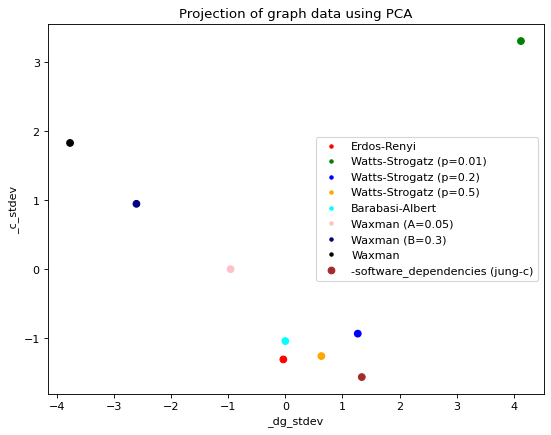

c. Watts-Strogatz


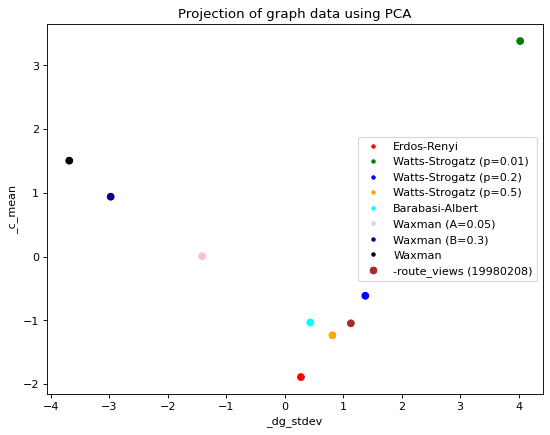

d. Watts-Strogatz


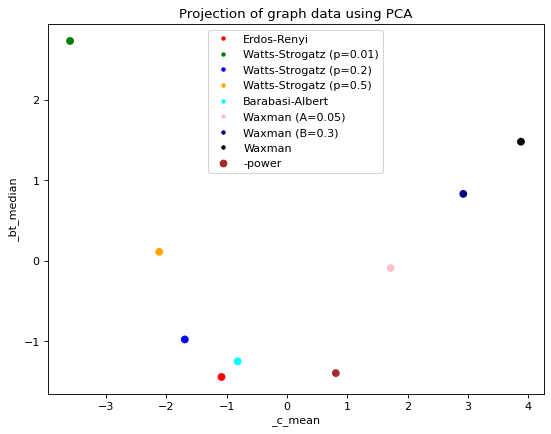

f. Waxman


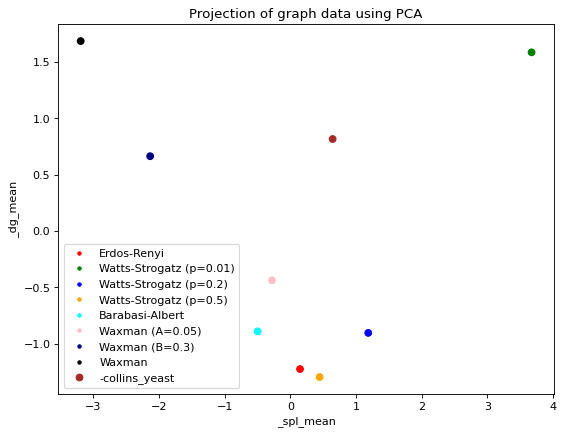

f. Waxman


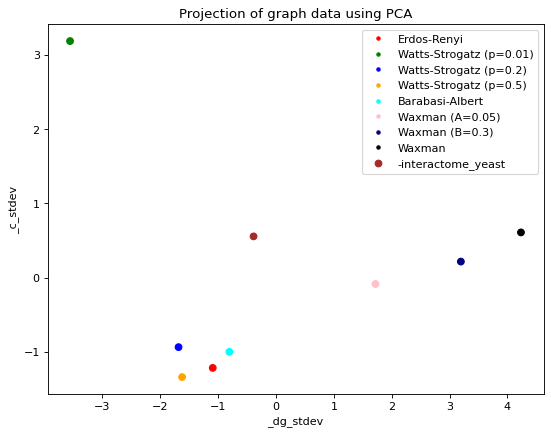

e. Barabasi-Albert


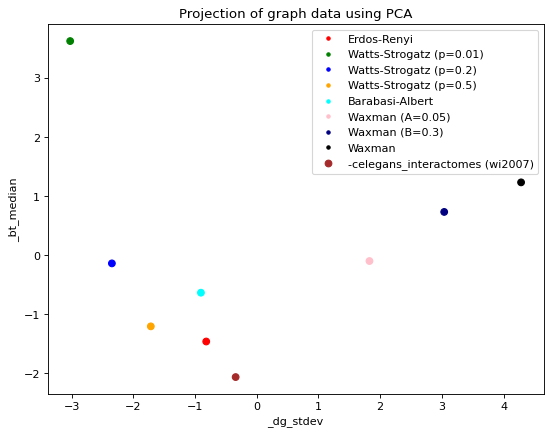

a. Erdos-Renyi


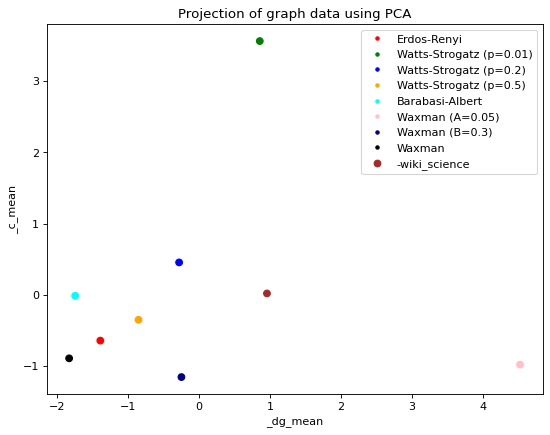

c. Watts-Strogatz


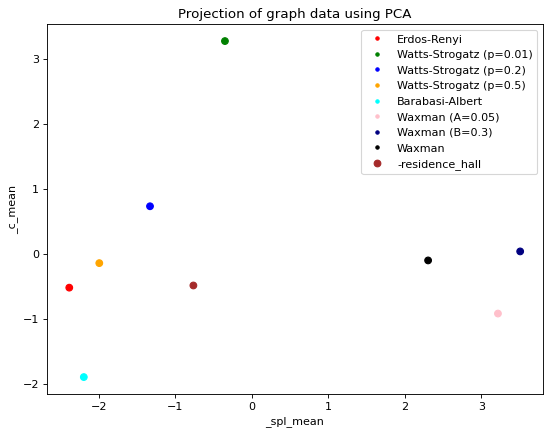

d. Watts-Strogatz


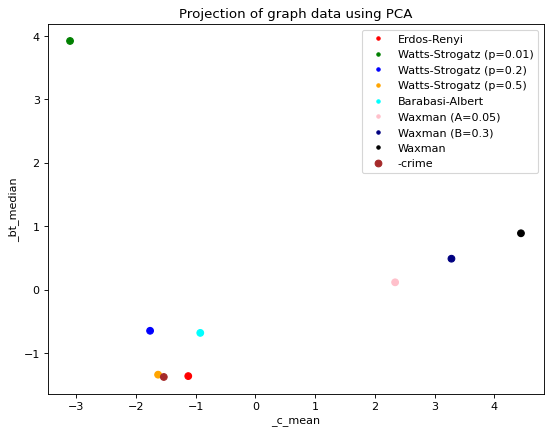

d. Watts-Strogatz


In [54]:
for graph_compare in graph_compare_list:
    graph_compare.make_pca()
    graph_compare.plot_pca()
    graph_compare.pca_file()
    graph_compare.make_knn()

Directory already exists!
